## TD Control for Machine Replacement

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [78]:
def maintenance_cost(state):
    return state**2 + state

def cost_function(state, action, replacement_cost):
    if action == 0:
        return replacement_cost + maintenance_cost(0)
    else:
        return maintenance_cost(state)

In [79]:
# set total number of states and define a transition probability matrix of that size
num_states = 10
replacement_cost = 50
transition_probability = np.zeros((2,num_states,num_states))

In [80]:
C = [[cost_function(i, j, replacement_cost) for i in range(num_states)] for j in range(2)]
C = np.array(C)
C

array([[50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
       [ 0,  2,  6, 12, 20, 30, 42, 56, 72, 90]])

In [81]:
def fill_transition_probability_matrix(transition_probability, p=0.5):
    for j in range(transition_probability.shape[1]-1):
        transition_probability[1][j][j] = p
        transition_probability[1][j][j+1] = 1-p
    for i in range(transition_probability.shape[1]):
        for j in range(transition_probability.shape[2]):
            transition_probability[0][i][j] = transition_probability[1][0][j]
    transition_probability[1, transition_probability.shape[1]-1, transition_probability.shape[1]-1] = 1



In [82]:
def policy_visualization(policy):
    plt.bar(range(num_states), policy)
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.show()

In [83]:
fill_transition_probability_matrix(transition_probability=transition_probability, p=0.2)
transition_probability

array([[[0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.2, 0.8, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.2, 0.8, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.2, 0.8, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. ,

In [84]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            return np.random.randint(0,2)
        else:
            return np.argmin(Q[s])

    def final_policy(self, s, Q):
        if s not in Q:
            return 0
        return np.argmin(Q[s])

In [85]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            return np.random.randint(0,2)
        else:
            return np.argmin(Q[s])

    def final_policy(self, s, Q):
        if s not in Q:
            return 0
        return np.argmin(Q[s])

Running SARSA with Epsilon-Greedy Policy...


100%|██████████| 100000/100000 [00:03<00:00, 25053.26it/s]


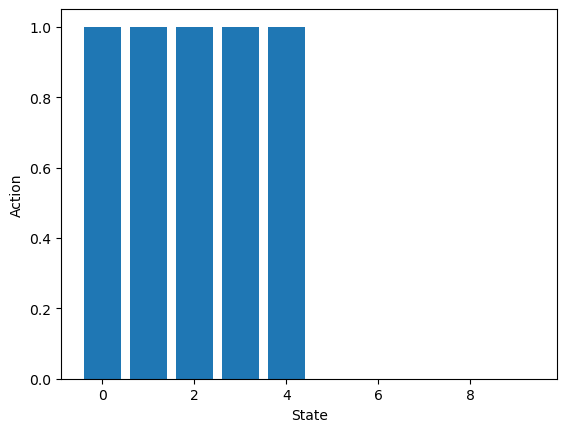

In [86]:
def sarsa(transition_probability, C, policy_class, alpha=0.1, gamma=0.5, max_steps=10000):
    Q = {}  # state-action value function
    policy = policy_class()

    # Track costs for convergence analysis
    Q_history_sarsa = []

    for step in tqdm(range(max_steps)):
        # Initialize episode
        state = np.random.randint(0, num_states)

        # Choose initial action using current policy
        action = policy.policy(state, Q)

        # Initialize Q(s,a) if not seen before
        if state not in Q:
            Q[state] = np.zeros(2)

        # Take action and observe cost and next state
        cost = C[action, state]

        # Sample next state based on transition probabilities
        next_state = np.random.choice(
            num_states,
            p=transition_probability[action, state, :]
        )

        # Choose next action using current policy
        next_action = policy.policy(next_state, Q)

        # Initialize Q(s',a') if not seen before
        if next_state not in Q:
            Q[next_state] = np.zeros(2)

        # SARSA update: Q(s,a) = Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
        # Note: we use negative cost as reward since we want to minimize cost
        reward = cost
        td_target = reward + gamma * Q[next_state][next_action]
        td_error = td_target - Q[state][action]
        Q[state][action] += alpha * td_error

        # Move to next state and action
        state = next_state
        action = next_action

        # store largest Q value for each state for convergence analysis
        Q_history_sarsa.append([np.min(Q[s]) if s in Q else 0 for s in range(num_states)])


        # Decay epsilon for epsilon-greedy policy
        if hasattr(policy, 'epsilon'):
            policy.update(max(0.001, policy.epsilon * 0.995))

    return Q, Q_history_sarsa, policy

# Run SARSA with epsilon-greedy policy
print("Running SARSA with Epsilon-Greedy Policy...")
Q_sarsa_final, Q_history, policy_eg = sarsa(
    transition_probability, C, EpsilonGreedyPolicy,
    alpha=0.1, gamma=0.5, max_steps=100000
)

# Extract final policy
final_policy_sarsa = [policy_eg.final_policy(s, Q_sarsa_final) for s in range(num_states)]
policy_visualization(final_policy_sarsa)


### Known optimal policy for N=10

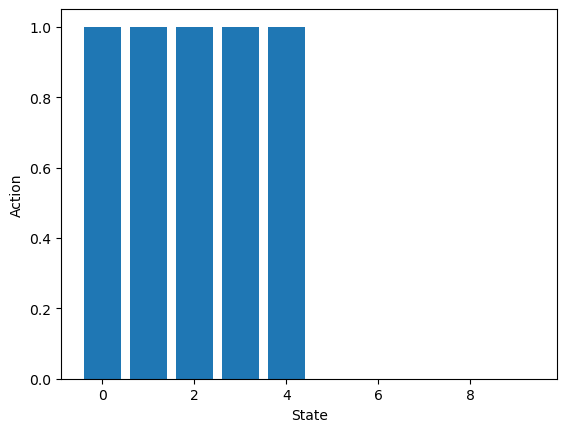

In [87]:
optimal_policy = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
policy_visualization(optimal_policy)

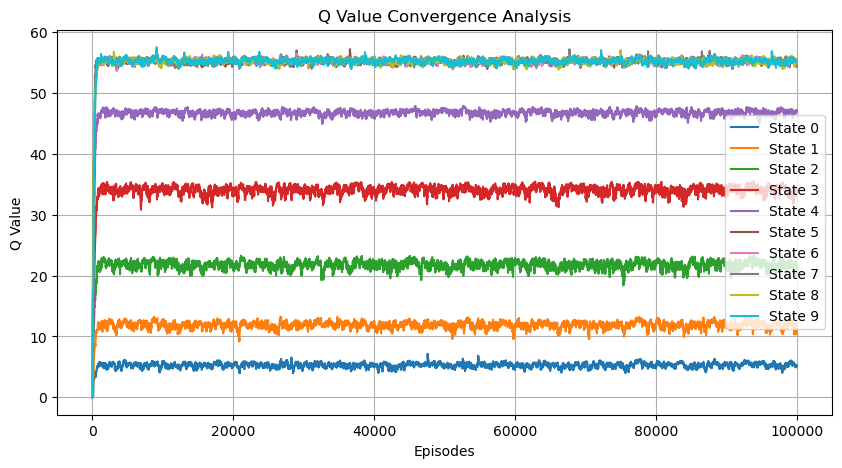

In [88]:
# Q value convergence analysis consider best Q value for each state
plt.figure(figsize=(10, 5))
# Plot the Q value for all states over episodes
for state in range(num_states):
    plt.plot(range(len(Q_history)), [Q[state] for Q in Q_history], label=f'State {state}')
plt.xlabel('Episodes')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

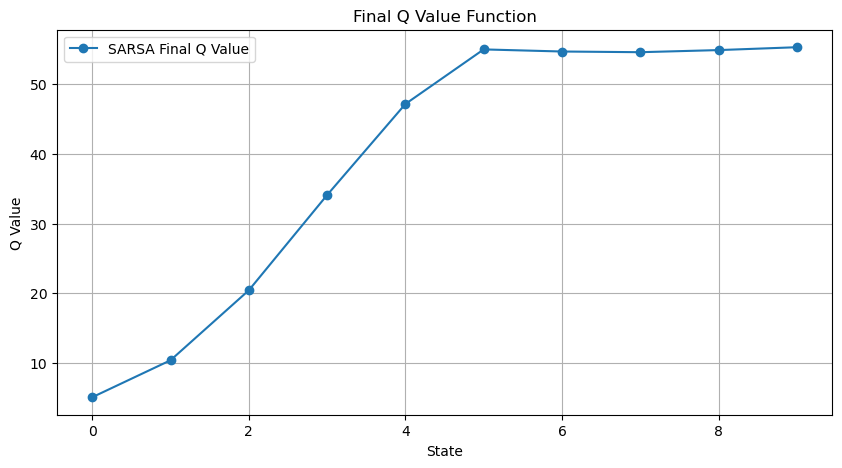

In [89]:
# plot final value function
plt.figure(figsize=(10, 5))
plt.plot(range(num_states), [np.min(Q_sarsa_final[s]) for s in range(num_states)], marker='o', label='SARSA Final Q Value')
plt.xlabel('State')
plt.ylabel('Q Value')
plt.title('Final Q Value Function')
plt.legend()
plt.grid()
plt.show()

In [90]:
def qlearning(transition_probability, C, policy_class, alpha=0.1, gamma=0.5, max_steps=10000):
    Q = {}  # state-action value function
    policy = policy_class()

    # Track costs for convergence analysis
    Q_history_qlearning = []

    for step in tqdm(range(max_steps)):
        # Initialize episode
        state = np.random.randint(0, num_states)

        # Choose initial action using current policy
        action = policy.policy(state, Q)

        # Initialize Q(s,a) if not seen before
        if state not in Q:
            Q[state] = np.zeros(2)

        # Take action and observe cost and next state
        cost = C[action, state]

        # Sample next state based on transition probabilities
        next_state = np.random.choice(
            num_states,
            p=transition_probability[action, state, :]
        )

        # Initialize Q(s',a') if not seen before
        if next_state not in Q:
            Q[next_state] = np.zeros(2)

        # Q-learning update: Q(s,a) = Q(s,a) + α[r + γmax_a'Q(s',a') - Q(s,a)]
        # Note: we use negative cost as reward since we want to minimize cost
        reward = cost
        td_target = reward + gamma * np.min(Q[next_state])
        td_error = td_target - Q[state][action]
        Q[state][action] += alpha * td_error

        # Move to next state and action
        state = next_state
        action = policy.policy(state, Q)

        # store largest Q value for each state for convergence analysis
        Q_history_qlearning.append([np.min(Q[s]) if s in Q else 0 for s in range(num_states)])

        # Decay epsilon for epsilon-greedy policy
        if hasattr(policy, 'epsilon'):
            policy.update(max(0.001, policy.epsilon * 0.995))

    return Q, Q_history_qlearning, policy

In [94]:
# Run Q-learning with epsilon-greedy policy
print("Running Q-learning with Epsilon-Greedy Policy...")
Q_qlearning_final, Q_history_qlearning, policy_eg = qlearning(
    transition_probability, C, EpsilonGreedyPolicy,
    alpha=0.1, gamma=0.5, max_steps=100000
)
# Extract final policy
final_policy_qlearning = [policy_eg.final_policy(s, Q_qlearning_final) for s in range(num_states)]

Running Q-learning with Epsilon-Greedy Policy...


100%|██████████| 100000/100000 [00:03<00:00, 25043.42it/s]


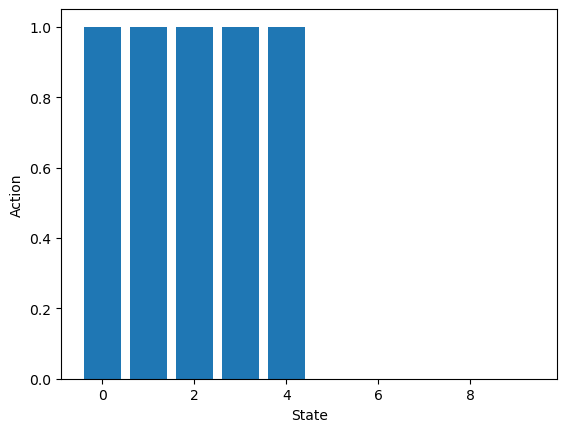

In [95]:
policy_visualization(final_policy_qlearning)

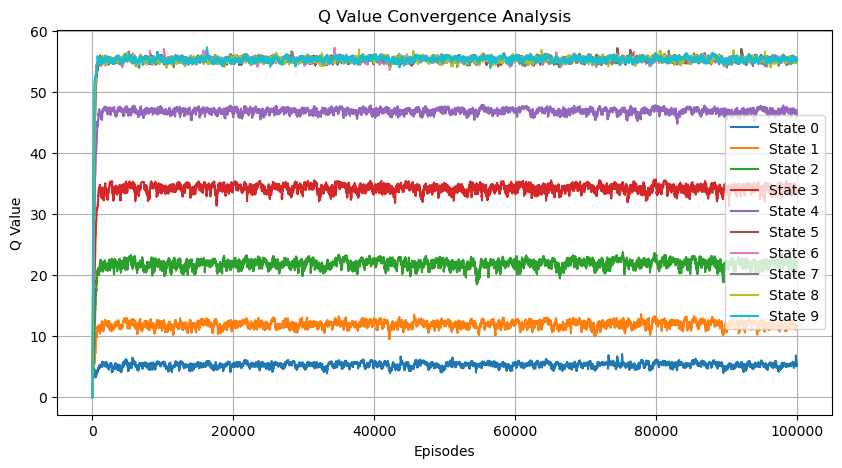

In [96]:
# Q value convergence analysis consider best Q value for each state
plt.figure(figsize=(10, 5))
# Plot the Q value for all states over episodes
for state in range(num_states):
    plt.plot(range(len(Q_history)), [Q[state] for Q in Q_history], label=f'State {state}')
plt.xlabel('Episodes')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

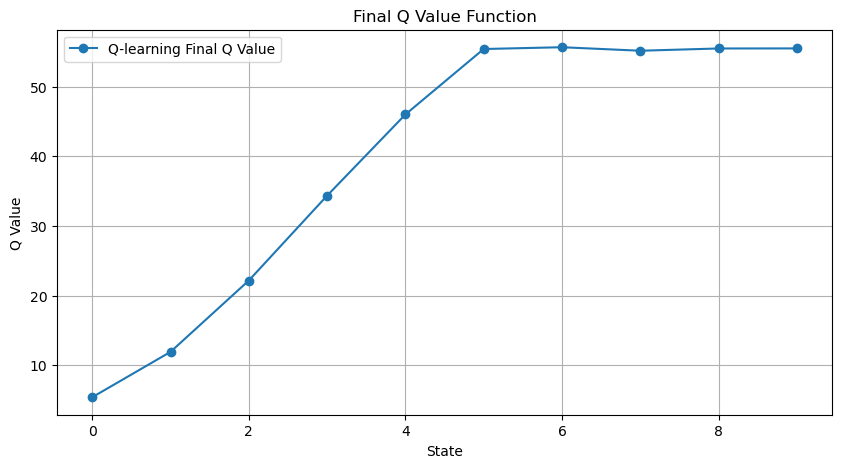

In [97]:
# plot final value function
plt.figure(figsize=(10, 5))
plt.plot(range(num_states), [np.min(Q_sarsa_final[s]) for s in range(num_states)], marker='o', label='Q-learning Final Q Value')
plt.xlabel('State')
plt.ylabel('Q Value')
plt.title('Final Q Value Function')
plt.legend()
plt.grid()
plt.show()